In [1]:
import sys
sys.path.append("/Users/ueki/.pyenv/versions/3.7.3/lib/python3.7/site-packages")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# Binary classification

## create data

In [35]:
# prepare dataset
np.random.seed(777)

In [36]:
# dataset 4
N = 200
D=4
x = 3 * (np.random.rand(N, 4) - 0.5)
y = (2 * x[:, 0] - 1 * x[:,1] + 0.5 + 0.5 * np.random.randn(N)) > 0
y = 2 * y -1
W_init= np.ones(D)

In [37]:
N_iter = 40

In [38]:
y.shape

(200,)

In [39]:
x.shape

(200, 4)

In [40]:
W_init.shape

(4,)

## batch steepest gradient method

### functions

In [44]:
def calc_loss(x,w,y):
    xy = x*y.reshape(-1,1)
    posterior = 1/(1+np.exp(np.dot(-xy,ww))) # (N,1)
    loss = np.average(np.log(1+np.exp(-y*np.dot(ww,x.T))),axis=0) #(scalar)
    return loss

In [45]:
def calc_grad(x,w,y):
    xy = x*y.reshape(-1,1)
    posterior = 1/(1+np.exp(np.dot(-xy,ww))) # (N,1)
    grad = np.average(-xy*(1-posterior.reshape(-1,1)),axis=0) #(D,1)
    return grad

In [43]:
def calc_hess(x,w,y):
    xy = x*y.reshape(-1,1)
    posterior = 1/(1+np.exp(np.dot(-xy,ww))) # (N,1)
    hess = np.average(xy**2*(posterior*(1-posterior)).reshape(-1,1),axis=0) #(D,1)
    return hess

### steepset gradient descent

In [46]:
#epoch
num_iter = N_iter
#重みの初期値
lam=0.01

In [47]:
grad_loss_history = []
grad_ww_history = []
lip = np.max(x**2)
alpha_base =1/ lip

In [48]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y) + 2*lam*ww
    loss = calc_loss(x,ww,y)+lam*(np.dot(ww.T,ww)+1) #(scalar)
    #history
    grad_ww_history.append(ww)
    grad_loss_history.append(loss)
    #update
    ww = ww - alpha_base*grad

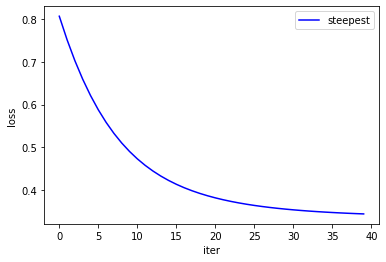

In [49]:
plt.plot(grad_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

### newton based method

In [50]:
#epoch
num_iter = N_iter
#learning history
newton_loss_history = []
newton_ww_history = []

In [51]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y) + 2*lam*ww
    loss = calc_loss(x,ww,y) + lam*(np.dot(ww.T,ww)+1)
    hess = calc_hess(x,ww,y)
    #history
    newton_ww_history.append(ww)
    newton_loss_history.append(loss)
    #update
    ww = ww - grad/hess

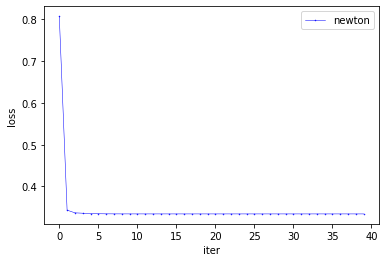

In [52]:
plt.plot( newton_loss_history, 'bo-', linewidth=0.5, markersize=0.5, label='newton')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## compare performance

In [53]:
optimal_w = min(min(grad_loss_history),min(newton_loss_history))

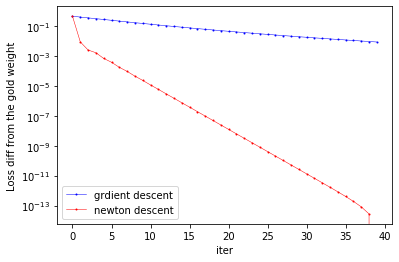

In [54]:
plt.plot(np.abs(grad_loss_history-optimal_w,),"bo-",linewidth=0.5,markersize=1,label="grdient descent")
plt.plot(np.abs(newton_loss_history-optimal_w),"ro-",linewidth=0.5,markersize=1,label="newton descent")
plt.legend()
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("Loss diff from the gold weight")
plt.show()

# adaptation to Multi class classification

## create Data (Toy dataset V)

In [55]:
# dataset 5
N = 200
D=3
N_class=4
x =3* (np.random.rand(N,D) - 0.5)
W_init = np.random.rand(N_class,D)
y = np.argmax(np.dot(np.hstack([x[:,:N_class-2],np.ones((N,1))]),W_init.T) + 0.5*np.random.randn(N,N_class),axis=1)

In [56]:
x.shape

(200, 3)

In [57]:
x = 3* (np.random.rand(N,D) - 0.5)
x.shape

(200, 3)

In [58]:
def to_categorical(y):
    """
    convert input vector y to one_hot_vector
    """
    size = np.max(y)
    y_one_hot = np.identity(size+1)[y]
    return y_one_hot

In [59]:
y_one_hot = to_categorical(y)

In [60]:
lam = 0.01
N_iter=50

## classification

### functions

In [61]:
def softmax(w):
    """
    paremeter
    ----------------
        w:  parameter
    ----------------
    return
    -------------
        soft_max : vec (N,D)
    """ 
    w = w.T
    exp_y= np.exp(w)
    exp_sum = np.sum(np.exp(w),axis=0) #　ここは良さそう
    ret = exp_y.T / exp_sum.reshape(-1,1)
    return ret.T

In [62]:
def calc_loss(x,w,ans):
    """
    ans: one_hot vector
    return
    ----------
    ret: scalar
    """
    v1 = np.sum((np.dot(y_one_hot,w.T)*x),axis=1)
    v2 =np.max(np.dot(x,ww.T),axis=1)
    loss = np.average(-v1+v2)
    return loss
    

In [63]:
def calc_grad(x,w,y_one_hot):
    """
    ret: grad shapes like w
    """
    s  = softmax(np.dot(ww,x.T))
    ret = np.zeros_like(w)
    #(N,D)と(N,C)から、(N,np.dot(D,C))を作る
    #それをNについてaverage
    ret =np.average(np.einsum("mij,mjk-> mik",s.reshape(N,-1,1),x.reshape(N,1,-1)),axis=0)
    return ret

In [64]:
def calc_hess(x,w,y_one_hot):
    """
    ret: hessian shapes like w
    """
    s = softmax(np.dot(ww,x.T))
    ret = np.zeros_like(w)
    return ret

## steepest gradient descent

In [65]:
#epoch
num_iter = N_iter
#learning history
steep_loss_history = []
steep_ww_history = []
lip = np.max(x**2)
alpha = 1/lip

In [66]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y_one_hot)+2*lam*ww
    loss = calc_loss(x,ww.T,y_one_hot)
    steep_ww_history.append(ww)
    steep_loss_history.append(loss)
    #update
    ww = ww-alpha*grad

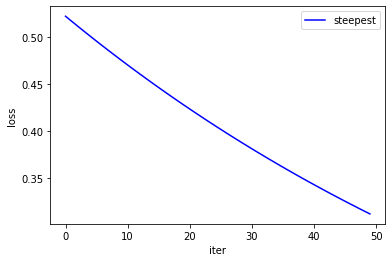

In [67]:
plt.plot(steep_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## Newton method

In [68]:
#epoch
num_iter = N_iter
#learning history
newton_loss_history = []
newton_ww_history = []

In [ ]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y_one_hot)+2*lam*ww # shape(ww)
    hess = calc_hess(x,ww.T,y_one_hot) + 2*lam # shape(ww)
    loss = calc_loss(x,ww.T,y_one_hot)  # shape(scalar)
    steep_ww_history.append(ww)
    steep_loss_history.append(loss)
    #update
    ww = ww-alpha_base*grad

In [ ]:
plt.plot(newton_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

In [ ]:
optimal_w = min(min(steep_loss_history),min(newton_loss_history))

In [ ]:
plt.plot(np.abs(steep_loss_history-optimal_w),label="grdient descent")
plt.plot(np.abs(newton_loss_history-optimal_w),label="newton descent")
plt.legend()
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("Loss diff from the gold weight")